In [1]:
import sys
import glob

import matplotlib.pyplot as plt
import iris
import iris.plot as iplt
from iris.experimental.equalise_cubes import equalise_attributes
import numpy as np
import cartopy.crs as ccrs

sys.path.append('/home/599/dbi599/ocean-analysis/modules')
import general_io as gio
import timeseries

## Process data

In [2]:
def regrid(cube):
    """Define the sample points for interpolation"""

    lats = list(np.arange(-89, 90, 2))
    lons = list(np.arange(1, 360, 2))
    
    sample_points = []
    coord_names = [coord.name() for coord in cube.dim_coords]
    if 'time' in coord_names:
        coord_names.remove('time')

    for coord in coord_names:
        if 'lat' in coord:
            sample_points.append((coord, lats))
        elif 'lon' in coord:
            sample_points.append((coord, lons))

    cube = cube.interpolate(sample_points, iris.analysis.Linear())
    cube.coord('latitude').guess_bounds()
    cube.coord('longitude').guess_bounds()
    
    cube.coord('latitude').standard_name = 'latitude'
    cube.coord('latitude').long_name = 'latitude'
    cube.coord('latitude').var_name = 'lat'
    cube.coord('latitude').units = 'degrees_north'
    cube.coord('latitude').attributes = {}
    #coord_system=iris.coord_systems.GeogCS(iris.fileformats.pp.EARTH_RADIUS))
                               
    cube.coord('longitude').standard_name = 'longitude'
    cube.coord('longitude').long_name = 'longitude'
    cube.coord('longitude').var_name = 'lon'
    cube.coord('longitude').units = 'degrees_east'
    cube.coord('longitude').circular = True
    cube.coord('longitude').attributes = {}
    # coord_system=iris.coord_systems.GeogCS(iris.fileformats.pp.EARTH_RADIUS))
        
    return cube

In [3]:
def get_cube_list(infiles, agg, time_bounds=None):
    """Read and process data."""

    assert agg in ['clim', 'anom']
    
    ensemble_cube_list = iris.cube.CubeList([])
    for ensnum, ensemble_member in enumerate(infiles):
        print(ensemble_member)
        cube, history = gio.combine_files(ensemble_member,
                                          'precipitation_minus_evaporation_flux',
                                          new_calendar='365_day')
        cube = gio.check_time_units(cube)
        if time_bounds:
            time_constraint = gio.get_time_constraint(time_bounds) 
            cube = cube.extract(time_constraint)
        if agg == 'clim':
            cube = timeseries.convert_to_annual(cube, aggregation='mean', days_in_month=True)
            cube = cube.collapsed('time', iris.analysis.MEAN)
        elif agg == 'anom':
            start_data = cube.data[0, ::]
            cube = cube[-1, ::]
            cube.data = cube.data - start_data 
        cube.remove_coord('time') 
        cube = regrid(cube)
        new_aux_coord = iris.coords.AuxCoord(ensnum, long_name='ensemble_member', units='no_unit')
        cube.add_aux_coord(new_aux_coord)
        cube.cell_methods = ()
        ensemble_cube_list.append(cube)
        print("Total number of models:", len(ensemble_cube_list))
    
    return ensemble_cube_list

In [4]:
def ensemble_stats(cube_list):
    """Get the ensemble mean and sign agreement"""
    
    equalise_attributes(cube_list)
    ensemble_cube = cube_list.merge_cube()
    
    ensemble_mean = ensemble_cube.collapsed('ensemble_member', iris.analysis.MEAN, mdtol=0)
    ensemble_mean.remove_coord('ensemble_member')
    
    ensemble_agreement = ensemble_mean.copy()
    nmodels = ensemble_cube.shape[0]
    pos_data = ensemble_cube.data > 0.0
    ensemble_agreement.data = pos_data.sum(axis=0) / nmodels
    
    return ensemble_mean, ensemble_agreement

In [21]:
def plot_data(ensemble_mean, ensemble_agreement, agg, agreement_bounds=None, clim=None):
    """Plot ensemble data"""

    assert agg in ['clim', 'anom']
    
    inproj = ccrs.PlateCarree()                  
    outproj = ccrs.PlateCarree(central_longitude=180.0)                    

    nrows = 1
    ncols = 1
    fig = plt.figure(figsize=[14, 6])

    ax = plt.subplot(nrows, ncols, 1, projection=outproj)
    plt.sca(ax)
    plt.gca().set_global()
    if agg == 'clim':
        ensmean_data = ensemble_mean.data * 86400
        cmap = 'BrBG'
        levels = np.arange(-7, 8, 1)
        cbar_label = 'Annual mean P-E (mm/day)'
        title = 'Climatology' 
    else:
        ensmean_data = ensemble_mean.data
        cmap = 'RdBu'
        levels = np.arange(-11000, 11050, 1100)
        cbar_label = 'Time-integrated anomaly (kg m-2)'
        title = "Time-integrated anomaly"
        
    x = ensemble_mean.coord('longitude').points
    y = ensemble_mean.coord('latitude').points
    cf = ax.contourf(x, y, ensmean_data,
                     transform=inproj,  
                     cmap=cmap,
                     levels=levels,
                     extend='both')

    if agreement_bounds:
        hatch_data = ensemble_agreement.data
        ax.contourf(x, y, hatch_data,
                    transform=inproj, 
                    colors='none',
                    levels=agreement_bounds,
                    hatches=['\\\\'],) # # '.', '/', '\\', '\\\\', '*'
    
    if clim:
        clim_data = clim.data * 86400
        ce = ax.contour(x, y, clim_data,
                        transform=inproj,
                        colors=['goldenrod', 'black', 'green'],
                        levels=np.array([-2, 0, 2]))
        
    cbar = plt.colorbar(cf)
    cbar.set_label(cbar_label)   #, fontsize=label_size)
    # cbar.ax.tick_params(labelsize=number_size)
    plt.gca().coastlines()
    ax.set_title(title)
    if agg == 'clim':
        lons = np.arange(-180, 180, 0.5)
        lats_sh = np.repeat(-20, len(lons))
        lats_nh = np.repeat(20, len(lons))
        plt.plot(lons, lats_sh, color='0.5') # linestyle, linewidth
        plt.plot(lons, lats_nh, color='0.5')

    plt.show()

## Climatology

In [6]:
clim_files = glob.glob('/g/data/e14/dbi599/CMIP?/CMIP/*/*/piControl/*/Amon/pe/*/*/pe*')
clim_files.sort()

In [ ]:
clim_ensemble_cube_list = get_cube_list(clim_files, 'clim')

/g/data/e14/dbi599/CMIP5/CMIP/CCCma/CanESM2/piControl/r1i1p1/Amon/pe/gn/v20120623/pe_Amon_CanESM2_piControl_r1i1p1_gn_201501-301012.nc
Total number of models: 1
/g/data/e14/dbi599/CMIP5/CMIP/CSIRO-QCCCE/CSIRO-Mk3-6-0/piControl/r1i1p1/Amon/pe/gn/v20110518/pe_Amon_CSIRO-Mk3-6-0_piControl_r1i1p1_gn_000101-050012.nc
Total number of models: 2
/g/data/e14/dbi599/CMIP5/CMIP/IPSL/IPSL-CM5A-LR/piControl/r1i1p1/Amon/pe/gn/v20130506/pe_Amon_IPSL-CM5A-LR_piControl_r1i1p1_gn_180001-279912.nc
Total number of models: 3
/g/data/e14/dbi599/CMIP5/CMIP/LASG-CESS/FGOALS-g2/piControl/r1i1p1/Amon/pe/gn/v20161204/pe_Amon_FGOALS-g2_piControl_r1i1p1_gn_020101-090012.nc
Total number of models: 4
/g/data/e14/dbi599/CMIP5/CMIP/NASA-GISS/GISS-E2-H/piControl/r1i1p1/Amon/pe/gn/v20160511/pe_Amon_GISS-E2-H_piControl_r1i1p1_gn_241001-294912.nc
Total number of models: 5
/g/data/e14/dbi599/CMIP5/CMIP/NASA-GISS/GISS-E2-R/piControl/r1i1p1/Amon/pe/gn/v20161004/pe_Amon_GISS-E2-R_piControl_r1i1p1_gn_398101-453012.nc


/g/data/r87/dbi599/miniconda3/envs/ocean3/lib/python3.7/site-packages/iris/coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))


Total number of models: 6
/g/data/e14/dbi599/CMIP5/CMIP/NCAR/CCSM4/piControl/r1i1p1/Amon/pe/gn/v20160829/pe_Amon_CCSM4_piControl_r1i1p1_gn_025001-130012.nc
Total number of models: 7
/g/data/e14/dbi599/CMIP5/CMIP/NCC/NorESM1-M/piControl/r1i1p1/Amon/pe/gn/v20110901/pe_Amon_NorESM1-M_piControl_r1i1p1_gn_070001-120012.nc
Total number of models: 8
/g/data/e14/dbi599/CMIP5/CMIP/NOAA-GFDL/GFDL-CM3/piControl/r1i1p1/Amon/pe/gn/v20120227/pe_Amon_GFDL-CM3_piControl_r1i1p1_gn_000101-050012.nc
Total number of models: 9
/g/data/e14/dbi599/CMIP5/CMIP/NOAA-GFDL/GFDL-ESM2M/piControl/r1i1p1/Amon/pe/gn/v20130214/pe_Amon_GFDL-ESM2M_piControl_r1i1p1_gn_000101-050012.nc
Total number of models: 10
/g/data/e14/dbi599/CMIP6/CMIP/BCC/BCC-CSM2-MR/piControl/r1i1p1f1/Amon/pe/gn/v20181016/pe_Amon_BCC-CSM2-MR_piControl_r1i1p1f1_gn_185001-244912.nc
Total number of models: 11
/g/data/e14/dbi599/CMIP6/CMIP/CAS/FGOALS-g3/piControl/r1i1p1f1/Amon/pe/gn/v20190818/pe_Amon_FGOALS-g3_piControl_r1i1p1f1_gn_060001-116012.nc
Tot

In [10]:
clim_ensemble_mean, clim_ensemble_agreement = ensemble_stats(clim_ensemble_cube_list)

/g/data/r87/dbi599/miniconda3/envs/ocean3/lib/python3.7/site-packages/iris/coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'ensemble_member'.
  warnings.warn(msg.format(self.name()))


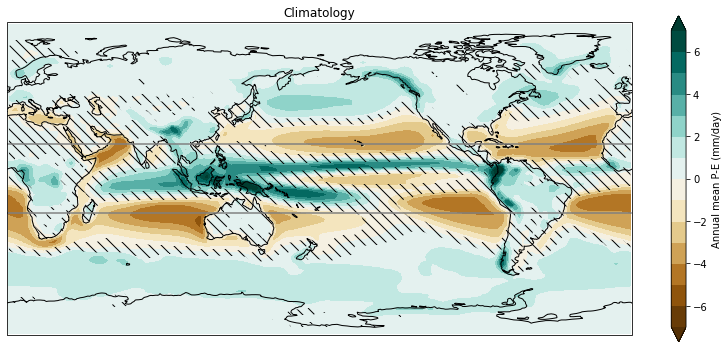

In [13]:
plot_data(clim_ensemble_mean, clim_ensemble_agreement, 'clim', agreement_bounds=[0.1, 0.9])

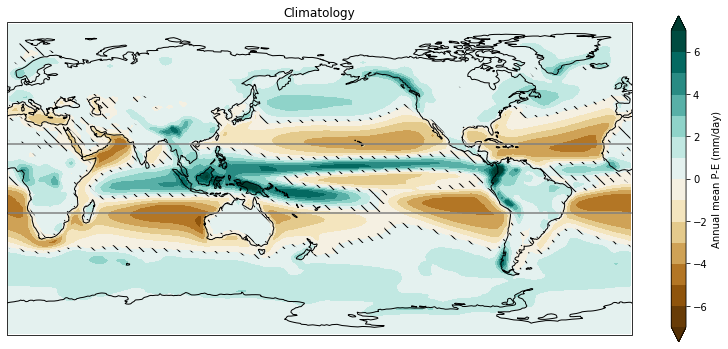

In [14]:
plot_data(clim_ensemble_mean, clim_ensemble_agreement, 'clim', agreement_bounds=[0.33, 0.66])

## historical

In [23]:
hist_files = glob.glob('/g/data/e14/dbi599/CMIP?/CMIP/*/*/historical/*/Ayr/pe/*/*/pe-anomaly_Ayr_*_historical_*_*_??????-??????-cumsum.nc')
hist_files.sort()

In [26]:
hist_ensemble_cube_list = get_cube_list(hist_files, 'anom')

/g/data/e14/dbi599/CMIP5/CMIP/CCCma/CanESM2/historical/r1i1p1/Ayr/pe/gn/v20120718/pe-anomaly_Ayr_CanESM2_historical_r1i1p1_gn_185001-200512-cumsum.nc
Total number of models: 1
/g/data/e14/dbi599/CMIP5/CMIP/CSIRO-QCCCE/CSIRO-Mk3-6-0/historical/r1i1p1/Ayr/pe/gn/v20110518/pe-anomaly_Ayr_CSIRO-Mk3-6-0_historical_r1i1p1_gn_185001-200512-cumsum.nc
Total number of models: 2
/g/data/e14/dbi599/CMIP5/CMIP/IPSL/IPSL-CM5A-LR/historical/r1i1p1/Ayr/pe/gn/v20110406/pe-anomaly_Ayr_IPSL-CM5A-LR_historical_r1i1p1_gn_185001-200512-cumsum.nc
Total number of models: 3
/g/data/e14/dbi599/CMIP5/CMIP/LASG-CESS/FGOALS-g2/historical/r1i1p1/Ayr/pe/gn/v1/pe-anomaly_Ayr_FGOALS-g2_historical_r1i1p1_gn_185001-201412-cumsum.nc
Total number of models: 4
/g/data/e14/dbi599/CMIP5/CMIP/NASA-GISS/GISS-E2-H/historical/r1i1p1/Ayr/pe/gn/v20160426/pe-anomaly_Ayr_GISS-E2-H_historical_r1i1p1_gn_185001-200512-cumsum.nc
Total number of models: 5
/g/data/e14/dbi599/CMIP5/CMIP/NASA-GISS/GISS-E2-R/historical/r1i1p1/Ayr/pe/gn/v20160

In [ ]:
hist_ensemble_mean, hist_ensemble_agreement = ensemble_stats(hist_ensemble_cube_list)

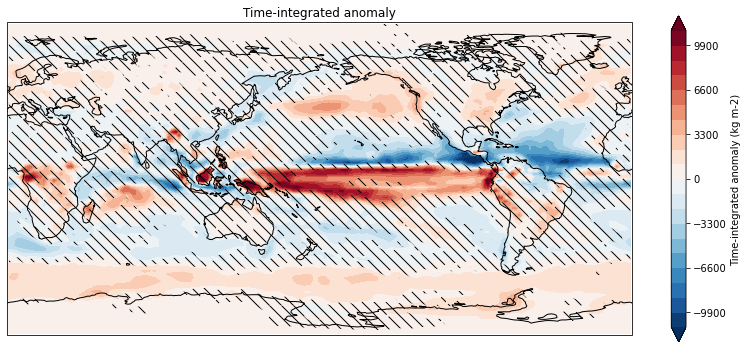

In [28]:
plot_data(hist_ensemble_mean, hist_ensemble_agreement, 'anom', agreement_bounds=[0.33, 0.66])

# GHG-only, time-integrated anomaly

In [6]:
ghg_files = glob.glob('/g/data/e14/dbi599/CMIP?/DAMIP/*/*/*GHG/*/Ayr/pe/*/*/pe-anomaly_Ayr_*_*GHG_*_*_??????-??????-cumsum.nc')
ghg_files.sort()

In [7]:
ghg_ensemble_cube_list = get_cube_list(ghg_files, 'anom')

/g/data/e14/dbi599/CMIP5/DAMIP/CCCma/CanESM2/historicalGHG/r1i1p1/Ayr/pe/gn/v20111027/pe-anomaly_Ayr_CanESM2_historicalGHG_r1i1p1_gn_185001-201212-cumsum.nc
Total number of models: 1
/g/data/e14/dbi599/CMIP5/DAMIP/CSIRO-QCCCE/CSIRO-Mk3-6-0/historicalGHG/r1i1p1/Ayr/pe/gn/v20110518/pe-anomaly_Ayr_CSIRO-Mk3-6-0_historicalGHG_r1i1p1_gn_185001-201212-cumsum.nc
Total number of models: 2
/g/data/e14/dbi599/CMIP5/DAMIP/IPSL/IPSL-CM5A-LR/historicalGHG/r1i1p1/Ayr/pe/gn/v20120526/pe-anomaly_Ayr_IPSL-CM5A-LR_historicalGHG_r1i1p1_gn_185001-201212-cumsum.nc
Total number of models: 3
/g/data/e14/dbi599/CMIP5/DAMIP/LASG-CESS/FGOALS-g2/historicalGHG/r1i1p1/Ayr/pe/gn/v20161204/pe-anomaly_Ayr_FGOALS-g2_historicalGHG_r1i1p1_gn_185001-200512-cumsum.nc
Total number of models: 4
/g/data/e14/dbi599/CMIP5/DAMIP/NASA-GISS/GISS-E2-H/historicalGHG/r1i1p1/Ayr/pe/gn/v20160426/pe-anomaly_Ayr_GISS-E2-H_historicalGHG_r1i1p1_gn_185001-201212-cumsum.nc
Total number of models: 5
/g/data/e14/dbi599/CMIP5/DAMIP/NASA-GISS/G

In [8]:
ghg_ensemble_mean, ghg_ensemble_agreement = ensemble_stats(ghg_ensemble_cube_list)

/g/data/r87/dbi599/miniconda3/envs/ocean3/lib/python3.7/site-packages/iris/coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'ensemble_member'.
  warnings.warn(msg.format(self.name()))


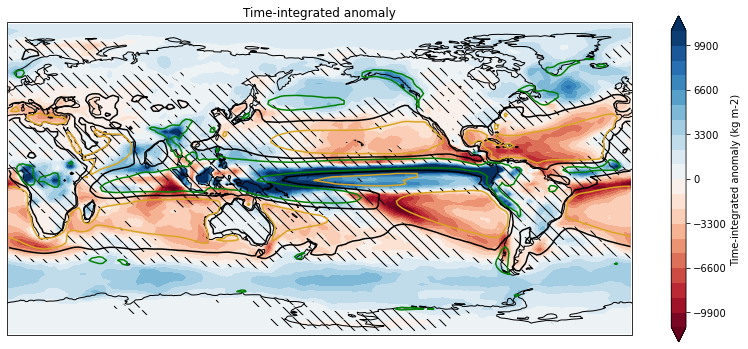

In [22]:
plot_data(ghg_ensemble_mean, ghg_ensemble_agreement, 'anom', agreement_bounds=[0.33, 0.66], clim=ghg_start_mean)

## GHG-only, epoch difference

In [9]:
ghg_epoch_files = glob.glob('/g/data/e14/dbi599/CMIP?/DAMIP/*/*/*GHG/*/Amon/pe/*/*/pe_Amon_*_*GHG_*_*_??????-??????.nc')
ghg_epoch_files.sort()

In [10]:
ghg_start_cube_list = get_cube_list(ghg_epoch_files, 'clim', time_bounds=['1861-01-01', '1870-12-31'])

/g/data/e14/dbi599/CMIP5/DAMIP/CCCma/CanESM2/historicalGHG/r1i1p1/Amon/pe/gn/v20111027/pe_Amon_CanESM2_historicalGHG_r1i1p1_gn_185001-201212.nc
Total number of models: 1
/g/data/e14/dbi599/CMIP5/DAMIP/CSIRO-QCCCE/CSIRO-Mk3-6-0/historicalGHG/r1i1p1/Amon/pe/gn/v20110518/pe_Amon_CSIRO-Mk3-6-0_historicalGHG_r1i1p1_gn_185001-201212.nc
Total number of models: 2
/g/data/e14/dbi599/CMIP5/DAMIP/IPSL/IPSL-CM5A-LR/historicalGHG/r1i1p1/Amon/pe/gn/v20120526/pe_Amon_IPSL-CM5A-LR_historicalGHG_r1i1p1_gn_185001-201212.nc
Total number of models: 3
/g/data/e14/dbi599/CMIP5/DAMIP/LASG-CESS/FGOALS-g2/historicalGHG/r1i1p1/Amon/pe/gn/v20161204/pe_Amon_FGOALS-g2_historicalGHG_r1i1p1_gn_185001-200512.nc
Total number of models: 4
/g/data/e14/dbi599/CMIP5/DAMIP/NASA-GISS/GISS-E2-H/historicalGHG/r1i1p1/Amon/pe/gn/v20160426/pe_Amon_GISS-E2-H_historicalGHG_r1i1p1_gn_185001-201212.nc
Total number of models: 5
/g/data/e14/dbi599/CMIP5/DAMIP/NASA-GISS/GISS-E2-R/historicalGHG/r1i1p1/Amon/pe/gn/v20160429/pe_Amon_GISS-E

In [23]:
ghg_end_cube_list = get_cube_list(ghg_epoch_files, 'clim', time_bounds=['1996-01-01', '2005-12-31'])

/g/data/e14/dbi599/CMIP5/DAMIP/CCCma/CanESM2/historicalGHG/r1i1p1/Amon/pe/gn/v20111027/pe_Amon_CanESM2_historicalGHG_r1i1p1_gn_185001-201212.nc
Total number of models: 1
/g/data/e14/dbi599/CMIP5/DAMIP/CSIRO-QCCCE/CSIRO-Mk3-6-0/historicalGHG/r1i1p1/Amon/pe/gn/v20110518/pe_Amon_CSIRO-Mk3-6-0_historicalGHG_r1i1p1_gn_185001-201212.nc
Total number of models: 2
/g/data/e14/dbi599/CMIP5/DAMIP/IPSL/IPSL-CM5A-LR/historicalGHG/r1i1p1/Amon/pe/gn/v20120526/pe_Amon_IPSL-CM5A-LR_historicalGHG_r1i1p1_gn_185001-201212.nc
Total number of models: 3
/g/data/e14/dbi599/CMIP5/DAMIP/LASG-CESS/FGOALS-g2/historicalGHG/r1i1p1/Amon/pe/gn/v20161204/pe_Amon_FGOALS-g2_historicalGHG_r1i1p1_gn_185001-200512.nc
Total number of models: 4
/g/data/e14/dbi599/CMIP5/DAMIP/NASA-GISS/GISS-E2-H/historicalGHG/r1i1p1/Amon/pe/gn/v20160426/pe_Amon_GISS-E2-H_historicalGHG_r1i1p1_gn_185001-201212.nc
Total number of models: 5
/g/data/e14/dbi599/CMIP5/DAMIP/NASA-GISS/GISS-E2-R/historicalGHG/r1i1p1/Amon/pe/gn/v20160429/pe_Amon_GISS-E

In [24]:
ghg_start_mean, ghg_start_agreement = ensemble_stats(ghg_start_cube_list)

/g/data/r87/dbi599/miniconda3/envs/ocean3/lib/python3.7/site-packages/iris/coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'ensemble_member'.
  warnings.warn(msg.format(self.name()))


In [25]:
ghg_end_mean, ghg_end_agreement = ensemble_stats(ghg_end_cube_list)

/g/data/r87/dbi599/miniconda3/envs/ocean3/lib/python3.7/site-packages/iris/coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'ensemble_member'.
  warnings.warn(msg.format(self.name()))


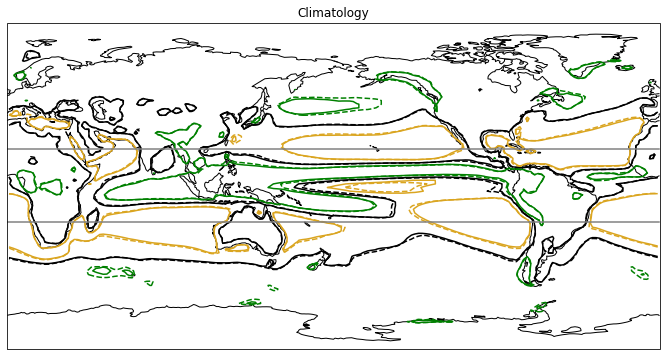

In [28]:
inproj = ccrs.PlateCarree()                  
outproj = ccrs.PlateCarree(central_longitude=180.0)                    

nrows = 1
ncols = 1
fig = plt.figure(figsize=[14, 6])

ax = plt.subplot(nrows, ncols, 1, projection=outproj)
plt.sca(ax)
plt.gca().set_global()
    
start_ensmean_data = ghg_start_mean.data * 86400
end_ensmean_data = ghg_end_mean.data * 86400
cmap = 'BrBG'
levels = np.array([-2, 0, 2])
cbar_label = 'Annual mean P-E (mm/day)'
title = 'Climatology' 
        
x = ghg_start_mean.coord('longitude').points
y = ghg_end_mean.coord('latitude').points
#cf = ax.contourf(x, y, start_ensmean_data,
#                 transform=inproj,  
#                 cmap=cmap,
#                 levels=levels,
#                 extend='both')

ce = ax.contour(x, y, start_ensmean_data,
                transform=inproj,
                colors=['goldenrod', 'black', 'green'],
                levels=levels)

ce = ax.contour(x, y, end_ensmean_data,
                transform=inproj,
                colors=['goldenrod', 'black', 'green'],
                levels=levels,
                linestyles='dashed')

#cbar = plt.colorbar(cf)
#cbar.set_label(cbar_label)   #, fontsize=label_size)
# cbar.ax.tick_params(labelsize=number_size)
plt.gca().coastlines()
ax.set_title(title)

lons = np.arange(-180, 180, 0.5)
lats_sh = np.repeat(-20, len(lons))
lats_nh = np.repeat(20, len(lons))
plt.plot(lons, lats_sh, color='0.5') # linestyle, linewidth
plt.plot(lons, lats_nh, color='0.5')

plt.show()